### IMPORT MODULES

In [1]:
import numpy as np

import py21cmfast as p21c
from py21cmfast import plotting
from py21cmfast import cache_tools
from py21cmfast.c_21cmfast import ffi, lib

from matplotlib import gridspec
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize,LogNorm

from hmf.mass_function import FittingFunction, PS
from hmf.halos import MassDefinition
from hmf import MassFunction

from timeit import default_timer as timer
from datetime import timedelta
from copy import deepcopy

/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


#### Define some constants and reference mass functions

In [2]:
cosmo_params = p21c.CosmoParams()
user_params = p21c.UserParams(HII_DIM=50,BOX_LEN=100,DIM=200,USE_INTERPOLATION_TABLES=True,N_THREADS=1,HMF=0)
astro_params = p21c.AstroParams()
flag_options = p21c.FlagOptions(USE_HALO_FIELD=True,HALO_STOCHASTICITY=True,USE_MASS_DEPENDENT_ZETA=True)

redshift = 8
redshift_update = 10
edges = np.logspace(7,13,num=64)
widths = np.diff(edges)
dlnm = np.log(edges[1:]) - np.log(edges[:-1])
centres = (edges[:-1] * np.exp(dlnm/2)).astype('f4')
volume = user_params.BOX_LEN**3
little_h = cosmo_params.cosmo.H0.to('km s-1 Mpc-1') / 100
random_seed = 24

class mf_delos(FittingFunction):
    _defaults = {"A": 0.658, "b": -0.582, "c": -1.056}
    @property
    def fsigma(self):
        A = self.params["A"]
        b = self.params["b"]
        c = self.params["c"]
        return A * self.sigma**b * np.exp(c / self.sigma**2)
    
mf_pkg_ps = MassFunction(z=redshift, Mmin=7, Mmax=15, cosmo_model=cosmo_params.cosmo, hmf_model="PS", transfer_model='EH')
mf_pkg_ps2 = MassFunction(z=redshift_update, Mmin=7, Mmax=15, cosmo_model=cosmo_params.cosmo, hmf_model="PS", transfer_model='EH')
# mf_pkg_st = MassFunction(z=redshift, Mmin=7, Mmax=15, cosmo_model=cosmo_params.cosmo, hmf_model="SMT", transfer_model='EH')
# mf_pkg_j = MassFunction(z=redshift, Mmin=7, Mmax=15, cosmo_model=cosmo_params.cosmo, hmf_model="Jenkins", transfer_model='EH')
# mf_pkg_d = MassFunction(z=redshift, Mmin=7, Mmax=15, cosmo_model=cosmo_params.cosmo, hmf_model=mf_delos, transfer_model='EH')

In [3]:
init_box = p21c.initial_conditions(user_params=user_params,
                                    cosmo_params=cosmo_params,
                                    random_seed=random_seed)

#### Run a single Halo Catalogue

In [4]:
halolist_init = p21c.determine_halo_list(redshift=redshift,
                                         init_boxes=init_box,
                                         user_params=user_params,
                                         cosmo_params=cosmo_params,
                                         astro_params=astro_params,
                                         flag_options=flag_options,
                                         random_seed=random_seed)

/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_utils.py:402: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(
2024-02-01 14:00:55 | DEBUG   | ps.c            | TFset_parameters:478 [pid=302479/thr=0] | Setting Transfer Function parameters.
2024-02-01 14:00:55 | DEBUG   | ps.c            | init_ps:633 [pid=302479/thr=0] | Initializing Power Spectrum with lower_limit=8.457500e-101, upper_limit=2.960125e+01, rel_tol=1.000000e-06, radius_8=11.8238
2024-02-01 14:00:55 | DEBUG   | ps.c            | init_ps:653 [pid=302479/thr=0] | Initialized Power Spectrum.
2024-02-01 14:00:56 | DEBUG   | Stochasticity.c | expected_nhalo:208 [pid=302479/thr=0] | Expected 1.18e+07 Halos in the box from masses 5.00e+07 to 3.15e+11 at z=8.00


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

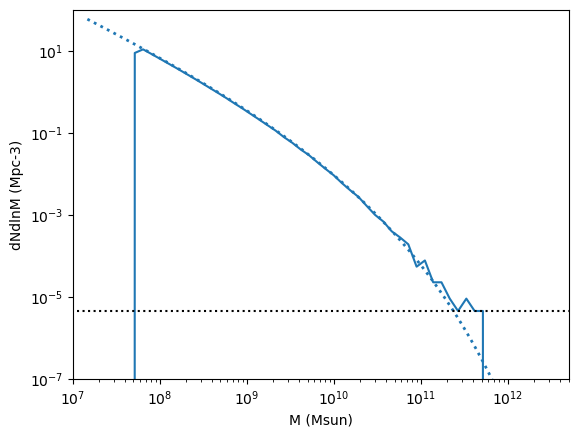

In [5]:
#get the mass function
masses = halolist_init.halo_masses
hist,_ = np.histogram(masses,edges)
mf = hist / volume / dlnm
plt.loglog(mf_pkg_ps.m/little_h,mf_pkg_ps.dndlnm*(little_h**3),color='C0',linewidth=2,linestyle=':')
plt.loglog(centres,mf,color='C0')
plt.loglog(centres,1/volume/dlnm,'k:')

plt.xlim([1e7,5e12])
plt.ylim([1e-7,1e2])
plt.ylabel('dNdlnM (Mpc-3)')
plt.xlabel('M (Msun)')
plt.show()

#### UPDATE TO ANOTHER REDSHIFT

2024-02-01 14:00:59 | DEBUG   | ps.c            | TFset_parameters:478 [pid=302479/thr=0] | Setting Transfer Function parameters.
2024-02-01 14:00:59 | DEBUG   | ps.c            | init_ps:633 [pid=302479/thr=0] | Initializing Power Spectrum with lower_limit=8.457500e-101, upper_limit=2.960125e+01, rel_tol=1.000000e-06, radius_8=11.8238
2024-02-01 14:00:59 | DEBUG   | ps.c            | init_ps:653 [pid=302479/thr=0] | Initialized Power Spectrum.
2024-02-01 14:00:59 | DEBUG   | Stochasticity.c | expected_nhalo:208 [pid=302479/thr=0] | Expected 5.07e+06 Halos in the box from masses 5.00e+07 to 3.15e+11 at z=10.00


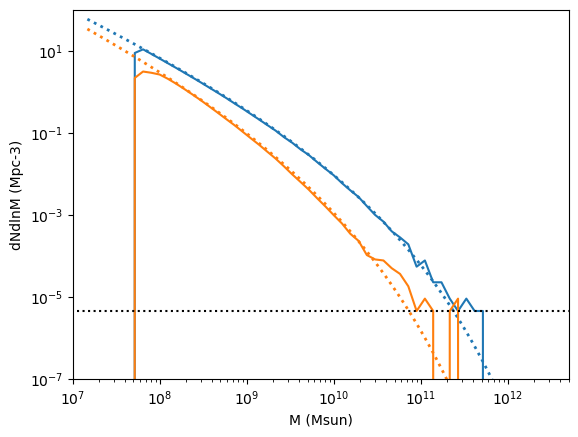

In [6]:
halolist_next = p21c.determine_halo_list(redshift=redshift_update,
                                         init_boxes=init_box,
                                         halos_desc=halolist_init)
#get the mass function
masses = halolist_next.halo_masses
hist,_ = np.histogram(masses,edges)
mf2 = hist / volume / dlnm
plt.loglog(mf_pkg_ps.m/little_h,mf_pkg_ps.dndlnm*(little_h**3),color='C0',linewidth=2,linestyle=':')
plt.loglog(centres,mf,color='C0')

plt.loglog(mf_pkg_ps2.m/little_h,mf_pkg_ps2.dndlnm*(little_h**3),color='C1',linewidth=2,linestyle=':')
plt.loglog(centres,mf2,color='C1')
plt.loglog(centres,1/volume/dlnm,'k:')

plt.xlim([1e7,5e12])
plt.ylim([1e-7,1e2])
plt.ylabel('dNdlnM (Mpc-3)')
plt.xlabel('M (Msun)')
plt.show()

In [7]:
#### KEEPS TRACK OF DESCENDANT HALOS

In [8]:
halolist_edit = deepcopy(halolist_init)
#add a bunch of large halos to the first catalogue
halomass_edit = halolist_edit.halo_masses
halomass_edit[halolist_edit.n_halos:halolist_edit.n_halos+1000] = 1e11
setattr(halolist_edit,'halo_masses',halomass_edit)
setattr(halolist_edit,'n_halos',halolist_edit.n_halos + 1000)

#call to pass memory to c
halolist_edit()
# print(halolist_edit.n_halos,halolist_init.n_halos)
# print(halolist_edit.halo_masses[halolist_edit.n_halos-15:halolist_edit.n_halos])

#the redshift difference is just a hack so it doesn't read the cache
halolist_next2 = p21c.determine_halo_list(redshift=redshift_update*1.001,
                                         halos_desc=halolist_edit,
                                         init_boxes=init_box,)

2024-02-01 14:01:01 | DEBUG   | ps.c            | TFset_parameters:478 [pid=302479/thr=0] | Setting Transfer Function parameters.
2024-02-01 14:01:01 | DEBUG   | ps.c            | init_ps:633 [pid=302479/thr=0] | Initializing Power Spectrum with lower_limit=8.457500e-101, upper_limit=2.960125e+01, rel_tol=1.000000e-06, radius_8=11.8238
2024-02-01 14:01:01 | DEBUG   | ps.c            | init_ps:653 [pid=302479/thr=0] | Initialized Power Spectrum.
2024-02-01 14:01:01 | DEBUG   | Stochasticity.c | expected_nhalo:208 [pid=302479/thr=0] | Expected 5.05e+06 Halos in the box from masses 5.00e+07 to 3.15e+11 at z=10.01


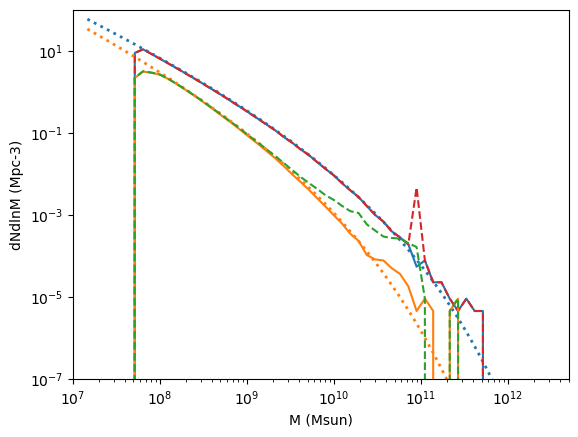

In [9]:
#get the mass function
masses = halolist_next2.halo_masses
hist,_ = np.histogram(masses,edges)
mf3 = hist / volume / dlnm

masses = halolist_edit.halo_masses
hist,_ = np.histogram(masses,edges)
mf4 = hist / volume / dlnm

plt.loglog(mf_pkg_ps.m/little_h,mf_pkg_ps.dndlnm*(little_h**3),color='C0',linewidth=2,linestyle=':')

plt.loglog(centres,mf,color='C0')
plt.loglog(centres,mf4,color='C3',linestyle='--')


plt.loglog(mf_pkg_ps2.m/little_h,mf_pkg_ps2.dndlnm*(little_h**3),color='C1',linewidth=2,linestyle=':')
plt.loglog(centres,mf2,color='C1')

#we should get a bump at higher masses < 1e11
plt.loglog(centres,mf3,color='C2',linestyle='--')

plt.xlim([1e7,5e12])
plt.ylim([1e-7,1e2])
plt.ylabel('dNdlnM (Mpc-3)')
plt.xlabel('M (Msun)')
plt.show()

#### HALO CATALOGUES CAN BE PERTURBED AND GRIDDED

In [10]:
pt_halos = p21c.perturb_halo_list(redshift=redshift,halo_field=halolist_init,init_boxes=init_box)

In [11]:
halo_box = p21c.halo_box(redshift=redshift,pt_halos=pt_halos,init_boxes=init_box)

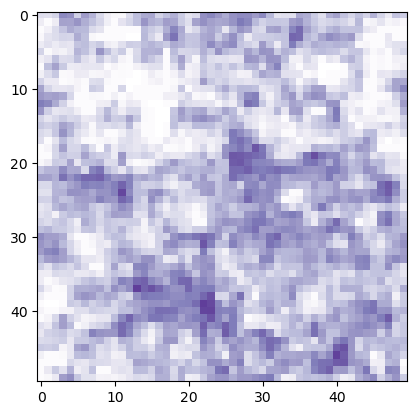

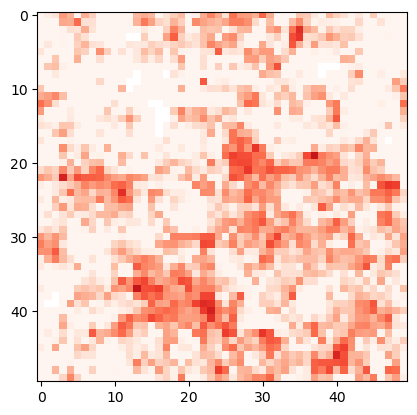

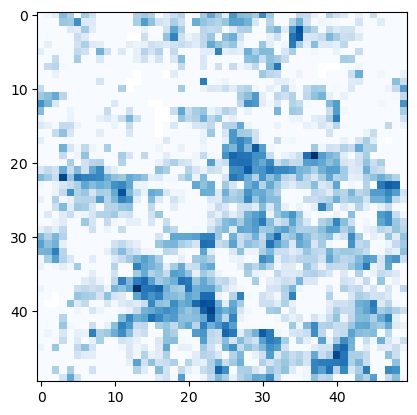

In [12]:
plt.figure()
plt.imshow(halo_box.halo_mass[...,0],cmap=cm.Purples,norm=LogNorm(vmin=1e8,vmax=1e11))
plt.show()
plt.imshow(halo_box.halo_stars[...,0],cmap=cm.Reds,norm=LogNorm(vmin=1e6,vmax=1e10))
plt.show()
plt.imshow(halo_box.halo_sfr[...,0],cmap=cm.Blues,norm=LogNorm(vmin=1e-11,vmax=1e-8))
plt.show()

In [13]:
#### Halo boxes can be used for IonisationBox

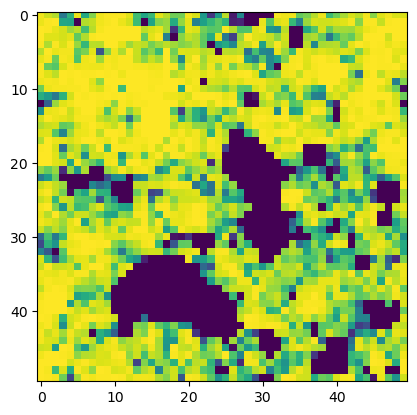

In [14]:
ionbox = p21c.ionize_box(halobox=halo_box)
plt.figure()
plt.imshow(ionbox.xH_box[...,0],cmap=cm.viridis,norm=Normalize(vmin=0,vmax=1))
plt.show()

In [15]:
#### Full lightcone run

2024-02-01 14:10:09 | DEBUG   | ps.c            | TFset_parameters:478 [pid=302479/thr=0] | Setting Transfer Function parameters.
2024-02-01 14:10:09 | DEBUG   | ps.c            | init_ps:633 [pid=302479/thr=0] | Initializing Power Spectrum with lower_limit=8.457500e-101, upper_limit=2.960125e+01, rel_tol=1.000000e-06, radius_8=11.8238
2024-02-01 14:10:09 | DEBUG   | ps.c            | init_ps:653 [pid=302479/thr=0] | Initialized Power Spectrum.
2024-02-01 14:10:09 | DEBUG   | Stochasticity.c | expected_nhalo:208 [pid=302479/thr=0] | Expected 1.18e+07 Halos in the box from masses 5.00e+07 to 3.15e+11 at z=8.00
2024-02-01 14:10:11 | DEBUG   | ps.c            | TFset_parameters:478 [pid=302479/thr=0] | Setting Transfer Function parameters.
2024-02-01 14:10:11 | DEBUG   | ps.c            | init_ps:633 [pid=302479/thr=0] | Initializing Power Spectrum with lower_limit=8.457500e-101, upper_limit=2.960125e+01, rel_tol=1.000000e-06, radius_8=11.8238
2024-02-01 14:10:11 | DEBUG   | ps.c         

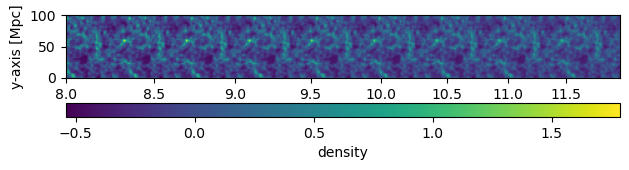

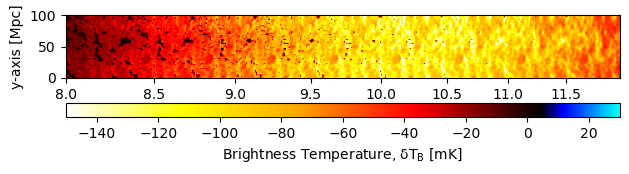

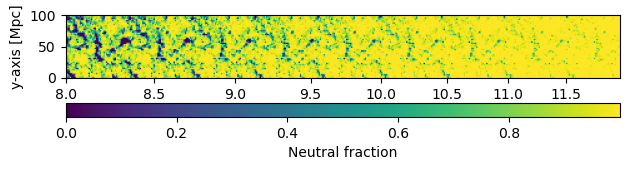

In [17]:
flag_options.update(USE_TS_FLUCT=True)
lightcone_quantities = ["density",'xH_box','brightness_temp']
lc = p21c.run_lightcone(
        redshift = redshift,
        max_redshift = 30,
        flag_options = flag_options,
        astro_params = astro_params,
        user_params = user_params,
        cosmo_params = cosmo_params,
        lightcone_quantities=lightcone_quantities,
        global_quantities=lightcone_quantities,
        random_seed = random_seed,
)
p21c.plotting.lightcone_sliceplot(lc,kind='density',zticks='redshift',aspect='equal'
                                                ,log=False,vertical=False,cbar_horizontal=True
                                                ,z_max=12,slice_index=24)
plt.show()
p21c.plotting.lightcone_sliceplot(lc,kind='brightness_temp',zticks='redshift',aspect='equal'
                                                ,log=False,vertical=False,cbar_horizontal=True
                                                ,z_max=12,slice_index=24)
plt.show()
p21c.plotting.lightcone_sliceplot(lc,kind='xH_box',zticks='redshift',aspect='equal'
                                                ,log=False,vertical=False,cbar_horizontal=True
                                                ,z_max=12,slice_index=24)
plt.show()